# Exploratory preprocessing

In this notebook we explore how lightkurve can simplify the data preprocessing steps conducted in `astronet` and later mimicked in `exonet`.

First we need [lightkurve](https://docs.lightkurve.org/), probably version 1.2 or above.

In [1]:
import lightkurve as lk

Now we need to understand what the preprocessing entails.  For that we can go to the [text of the original paper](http://adsabs.harvard.edu/abs/2018AJ....155...94S) in Section 3.2 titled "Light Curves":

> We then performed a few additional steps to prepare the light curves to be used as inputs to our neural network. For each TCE in the training set, we removed points corresponding to transits of any other confirmed planets in the system. Then, we "flattened" the light curve (that is, we removed low-frequency variability) by fitting a basis spline to the light curve and dividing it by the best-fit spline. To preserve transits, we removed the TCE's in-transit points while fitting the spline and linearly interpolated over those transits. We iteratively fit the spline, removed $3\sigma $ outliers, and refit the spline while interpolating over those outliers to prevent the spline from being "pulled" by discrepant points like cosmic-ray hits. This process is illustrated in Figure 3 of Vanderburg & Johnson (2014).

The next paragraph goes on to describe the method for getting the spline breakpoints.

**Section 3.3** then describes the *Input Representations*:

> We generate a **global view** of the light curve by choosing λ as a fraction of the TCE period. All light curves are binned to the same length, and each bin represents the same number of points, on average, across light curves. A disadvantage is that long-period TCEs may end up with very narrow transits that fall entirely within a small number of bins...

> We generate a **local view** of the transit by choosing λ as a fraction of the TCE duration. We consider k transit durations on either side of the event so that the transit occupies a fixed fraction of the resulting vector. This technique represents short- and long-period TCEs equally, but it only looks at part of the curve and therefore may miss important information, such as secondary eclipses 

The section concludes with a normalization procedure to make the transits all the same depth:

> ...we normalize all light curves to have median 0 and minimum value –1 so that all TCEs have a fixed transit depth.

Ok, let's see how far we can get with lightkurve:

First we'll need a mapping of target names (*e.g.* Kepler Input Catalog KIC IDs), to their respective, possibly multiple, Threshold Crossing Events.  That information is available in the DR24 products used by astronet and exonet, and soon to be updated to DR25.  For now we will [query the NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=q1_q17_dr24_tce) and save the output as an IPAC table in the `../data` directory.

In [2]:
! head -n 20 ../data/q1_q17_dr24_tce_2019.10.02_16.14.06.tbl

\ This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
\ Wed Oct  2 16:14:06 2019
\
\ COLUMN kepid:          KepID
\ COLUMN tce_plnt_num:   Planet Number
\ COLUMN tce_rogue_flag: Rogue Flag
\ COLUMN tce_delivname:  Delivery Name
\ COLUMN rowupdate:      Date of Last Update
\ COLUMN tce_datalink_dvs: Link to DV Summary
\ COLUMN tce_datalink_dvr: Link to DV Report
\ COLUMN tce_period:     Orbital Period [days]
\ COLUMN tce_period_err: Orbital Period Unc. [days]
\ COLUMN tce_time0bk:    Transit Epoch [BKJD]
\ COLUMN tce_time0bk_err: Transit Epoch Unc. [BKJD]
\ COLUMN tce_time0:      Transit Epoch [BJD]
\ COLUMN tce_time0_err:  Transit Epoch Unc. [BJD]
\ COLUMN tce_ror:        Planet-Star Radius Ratio
\ COLUMN tce_ror_err:    Planet-Star Radius Ratio Unc.
\ COLUMN tce_dor:        Planet-Star Distance over Star Radius
\ COLUMN tce_dor_err:    Planet-Star Distance over Star Radius Unc.


In [3]:
from astropy.io import ascii

In [4]:
tbldr24 = ascii.read('../data/q1_q17_dr24_tce_2019.10.02_16.14.06.tbl')

The most useful columns are:
1. `kepid`
2. `tce_plnt_num`
3. `tce_period` and `tce_period_err`
4. `tce_time0bk` and `tce_time0bk_err`
5. `tce_ror` and `tce_ror_err` (is this radius?)
6. `tce_duration` and `tce_duration_err`
7. `tce_depth` and `tce_depth_err`

In [5]:
dr24_tce = tbldr24[['kepid', 'tce_plnt_num', 'tce_period', 'tce_time0bk', 'tce_duration', 'tce_depth']].to_pandas()

We'll eventually need to iterate over the other TCEs (if any) in a given target, so it's useful to have a "total number of TCEs" columns readily availble:

In [6]:
import pandas as pd

In [7]:
tce_num_per_star = dr24_tce.groupby('kepid').tce_plnt_num.apply(lambda x:len(x.unique()))
dr24_tce= pd.merge(dr24_tce, 
                   tce_num_per_star.to_frame().rename(columns={'tce_plnt_num':'tot_plnts'}),
                    how='left',on='kepid')

Let's spot check one of these TCEs:

In [8]:
dr24_tce.head(15)

,kepid,tce_plnt_num,tce_period,tce_time0bk,tce_duration,tce_depth,tot_plnts
0,1162345,2,0.831850,132.227,2.392,6.092,3
1,1292087,2,1.095240,132.133,2.122,34.530,2
2,1293031,2,0.719273,132.227,1.521,29.680,2
3,1162345,3,0.831833,131.919,2.181,27.100,3
4,1164109,1,622.408000,162.256,12.010,161.300,1
5,757450,1,8.884920,134.452,2.078,16310.000,1
6,892667,1,2.262110,132.171,7.509,29.410,1
7,892772,1,5.092600,133.451,3.399,246.500,1
8,1026032,1,8.460440,133.774,4.804,76500.000,2
9,1026032,2,4.230220,133.998,4.606,28810.000,2


### An eclipsing binary

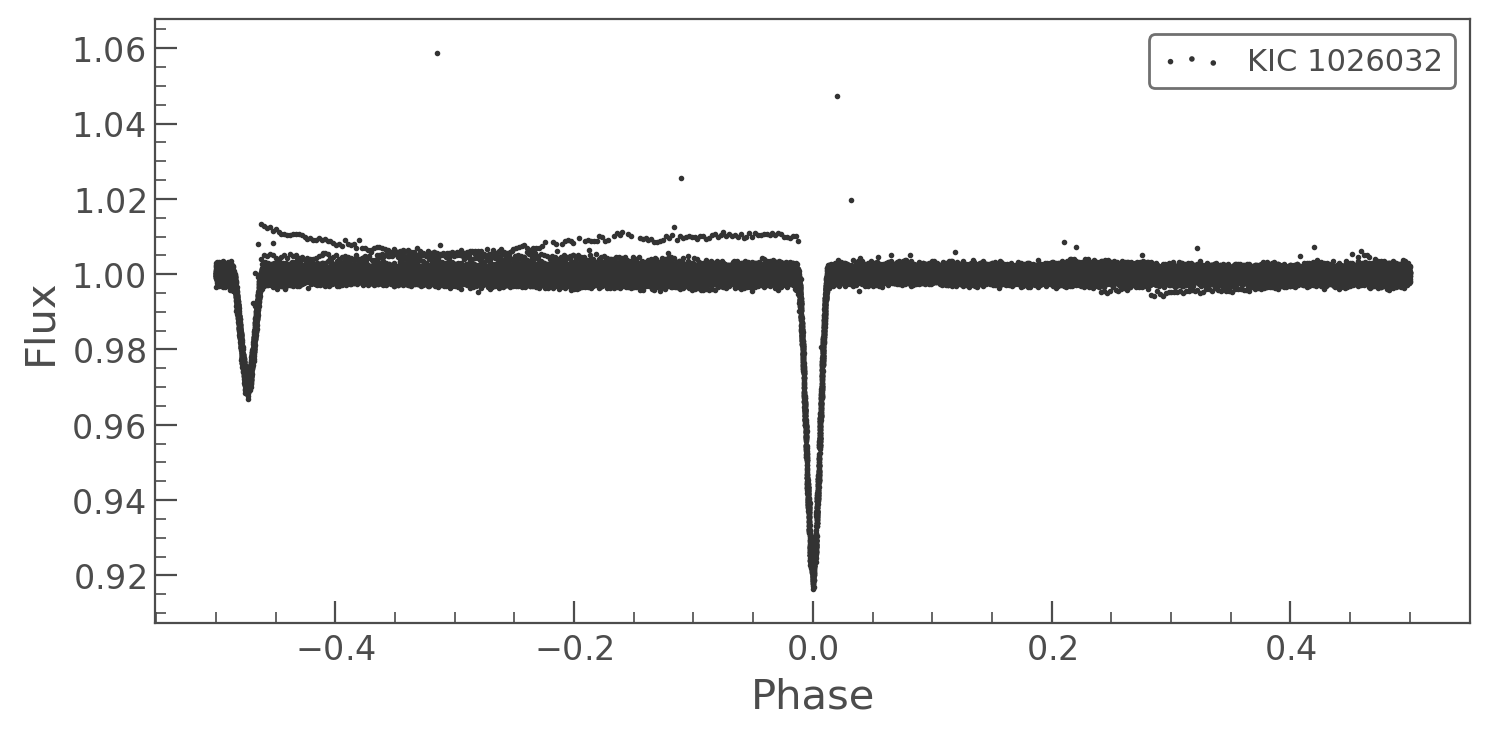

In [9]:
lcfs = lk.search_lightcurvefile('KIC 1026032', mission='Kepler').download_all()
lcfs.PDCSAP_FLUX.stitch().fold(8.460440, t0=133.774).scatter();

Un-binned global view shows a distinctive EB pattern-- deep primary eclipse with a secondary eclipse situated at almost half phase away.

### A likely planet

In [10]:
lcfs = lk.search_lightcurvefile('KIC 1026957', mission='Kepler').download_all()

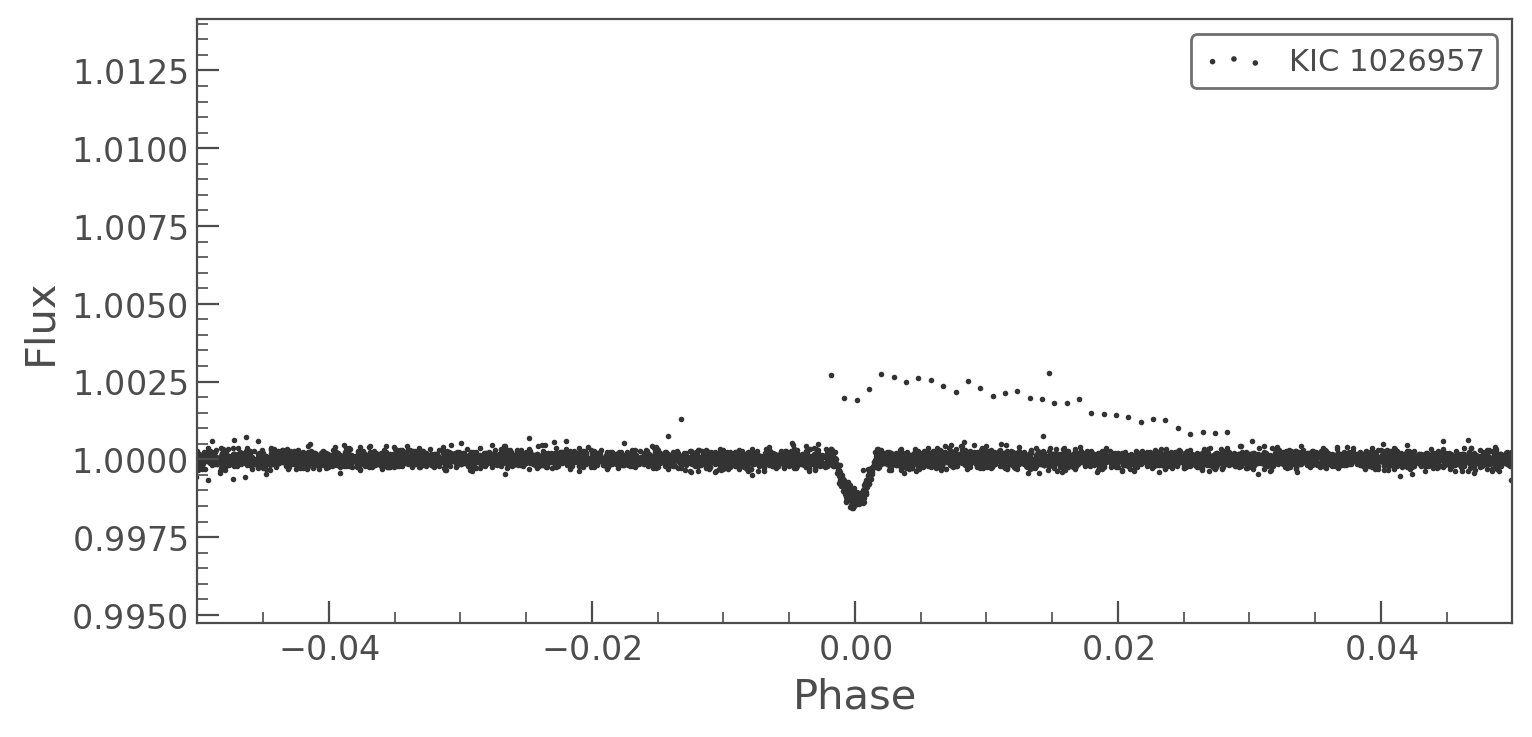

In [11]:
ax = lcfs.PDCSAP_FLUX.stitch(corrector_func= lambda lc: lc.flatten().normalize()).fold(21.761300, t0=144.779).scatter()
ax.set_xlim(-0.05, 0.05);

Un-binned local view shows a distinctive exoplanet transit appearance.  Some flattening artifacts remain.

## Takeaways and next steps

We need to mask the transits (from all TCEs in a given source).  There's not an out-of-the-box way to do this in lightkurve.  The high dynamic range of stellar variations makes it difficult to set a single flattening parameter, akin to the need to grid search over the spline knot distance in the Shallue & Vanderburg text.  We still may want to use a GP-- in some ways it's easier, even if diminishing marginal returns.  Finally we still have to bin and normalize, which is straightforward.